In [108]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../../src/scenes/')
import syndiff as sd 

from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize
from astropy.stats import sigma_clipped_stats
from glob import glob
from correct_saturation import saturated_stars, _get_bsc, SkyCoord, image2counts, query_ps1
from astropy.io import fits
from astropy.wcs import WCS
import tessreduce as tr
from PRF import TESS_PRF

from photutils.aperture import CircularAperture, CircularAnnulus,RectangularAperture
from photutils.aperture import ApertureStats, aperture_photometry

from correct_saturation import ps_psf, psf_minimizer, minimize,PS1_to_TESS_mag
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import time
import pandas as pd

In [2]:
tess_filename = '../data/tess2019360165923-s0020-1-1-0165-s_ffic.fits'
tess_hdu = fits.open(tess_filename)
tess_wcs = WCS(tess_hdu[1].header)
tess_data = tess_hdu[1].data

t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]
ty = ty.ravel().astype(int)
tx = tx.ravel().astype(int)

ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')

ps1_assignment = np.load('test_assignment.npy').astype(int)

In [5]:
ra,dec = tess_wcs.all_pix2world(tess_data.shape[1]/2,tess_data.shape[1]/2,0)
print(ra,dec)
size = 2000
y, x = np.mgrid[:size, :size]
x = x - size/2; y = y - size/2
psfg = models.Gaussian2D(x_stddev=70,y_stddev=70)
psfg = psfg(x,y)
psfg /= np.nansum(psfg)

120.110378130205 44.954336133035945


In [83]:
hdu = fits.open(ps1_files[0])
header = hdu[0].header
ps1_wcs = WCS(header)
data = image2counts(hdu[0].data,header)

In [93]:
ps1_files[0]

'../data/ps1_skycell/rings.v3.skycell.2246.012.stk.i.unconv.satcor.fits'

<IPython.core.display.Javascript object>


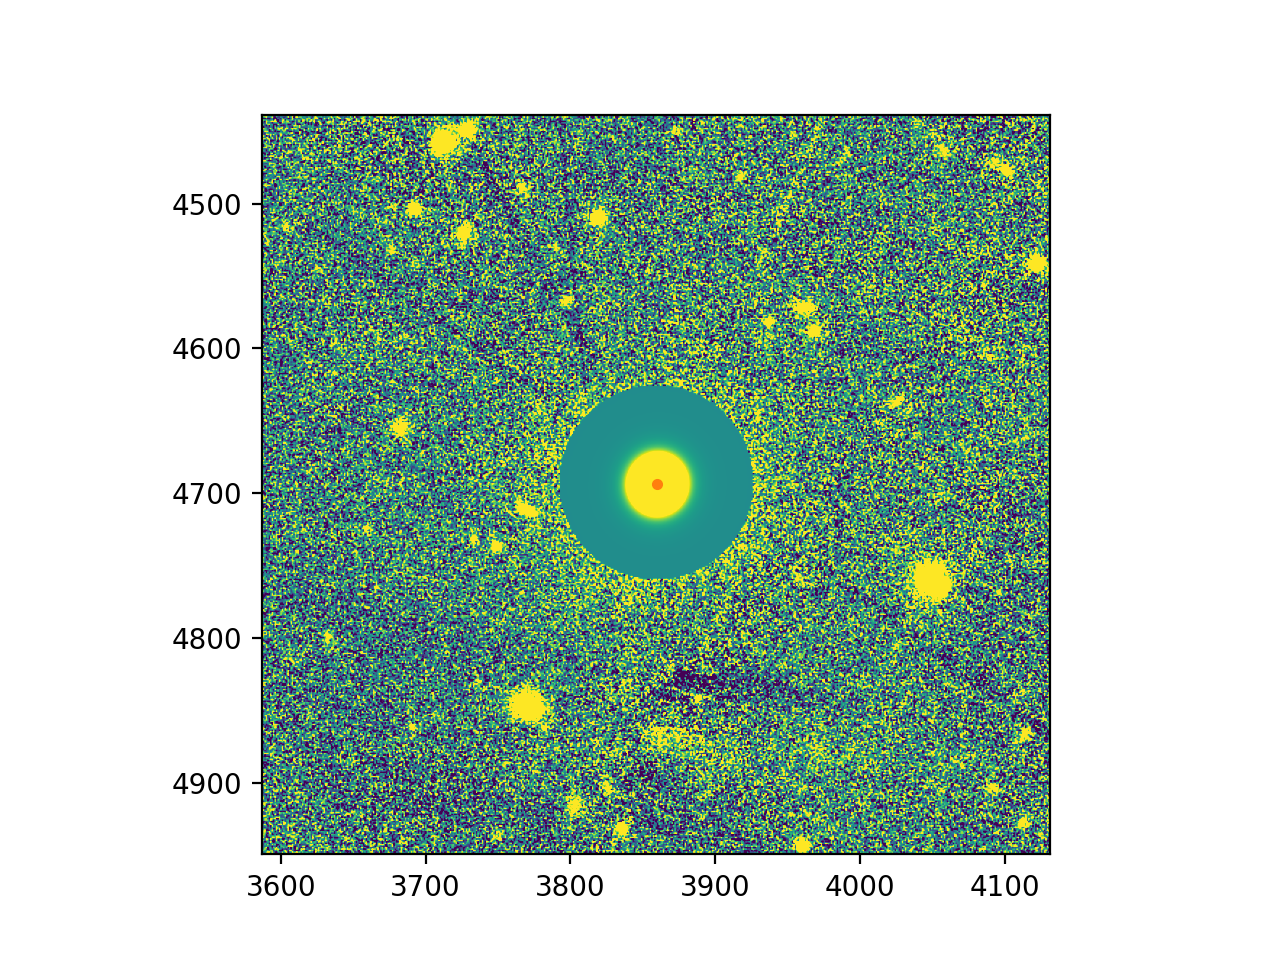

In [92]:
r_, d_ = ps1_wcs.all_pix2world(3861,4693,0)
x_,y_ = ps1_wcs.all_world2pix(r_,d_,0)

x,y = ps1_wcs.all_world2pix(119.47822169330,44.68784745750,0)
vmin = np.percentile(data,16)
vmax = np.percentile(data,84)
plt.figure()
plt.imshow(data,vmin=vmin,vmax=vmax)
plt.plot(x,y,'C1.')
#plt.plot(x_,y_,'C1*')

In [90]:
r_,d_

(array(119.47811503), array(44.68779165))

In [86]:
ps1_wcs.all_pix2world(3861,4693,0)

[array(119.47811503), array(44.68779165)]

In [79]:
ps1 = {}
cor = []
for file in ps1_files:
    hdu = fits.open(file)
    header = hdu[0].header

    data = image2counts(hdu[0].data,header)
    m,med,std = sigma_clipped_stats(data)
    ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    cor += [header['FLUXFACT']]
cor = np.array(cor)
ps1_wcs = WCS(header)

noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')


KeyError: 'r'

In [ ]:
breaks[i]:breaks[i+1]]

In [ ]:
plt.figure()
plt.hist()

In [24]:
pind = ps1_assignment.ravel()
tess_pixels = np.unique(pind)[1:]
start = time.time()
pind = ps1_assignment.ravel()
sort_ind = np.argsort(pind)
ps1_tess_rav = ps1_tess.ravel()[sort_ind]
breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
breaks = np.insert(breaks,-1,len(ps1_tess_rav))


sums = []
for i in range(len(breaks)-1):
    # first entry is 0, which is not assigned, so we can skip it
    sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]
    
scene = np.zeros_like(tess_data)
scene[ty[tess_pixels],tx[tess_pixels]] = sums
print('Time: %s' % (time.time()-start))

Time: 0.7441327571868896


<IPython.core.display.Javascript object>


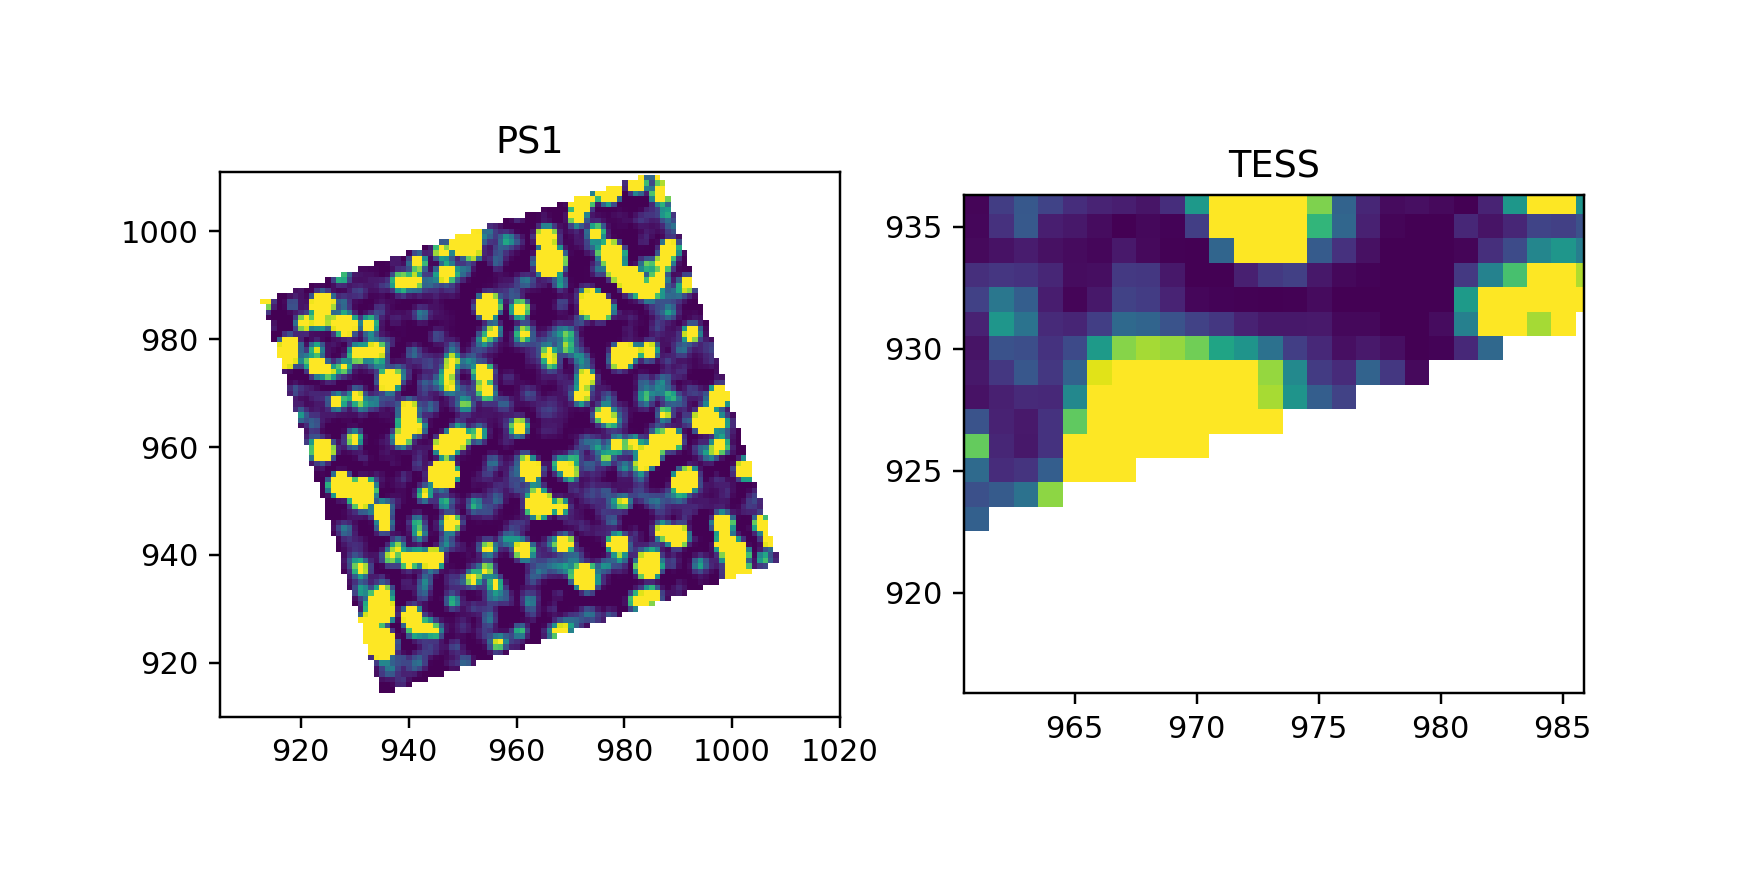

(910.0, 1011.0)

In [26]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

xmin = np.where(np.isfinite(s))[0][0] - 10
xmax = np.where(np.isfinite(s))[0][-1] + 10
ymin = np.where(np.isfinite(s))[1][0] - 10
ymax = np.where(np.isfinite(s))[1][-1] + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [ ]:
cat = query_ps1(ra,dec,0.4)
px,py = ps1_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['ps1x'] = px; cat['ps1y'] = py
_tx,_ty = tess_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = _tx; cat['tessy'] = _ty
cat = PS1_to_TESS_mag(cat)

In [29]:
sub = cat.loc[(cat.iMeanPSFMag < 17) ]# & (cat.rMeanPSFMag > 12)
#sub = cat.loc[(cat.tmag < 14) & np.isfinite(cat.tmag)  & (cat.rMeanPSFMag > 14)]
ind = ((sub.ps1x.values>100) & (sub.ps1x.values<ps1_tess.shape[1]-100) & 
       (sub.ps1y.values>100) & (sub.ps1y.values<ps1_tess.shape[0]-100) & 
       (sub.tessy.values>2) & (sub.tessy.values<tess_data.shape[0]-2) &
       (sub.tessx.values>2) & (sub.tessx.values<tess_data.shape[1]-2))

sub = sub.loc[ind]

subsub = sub.iMeanPSFMag.values >14

In [40]:
scale = 21/0.25
ap_size = 2
pos = list(zip(sub.tessx, sub.tessy))
taperture = CircularAperture(pos, ap_size)
a = tess_data
m,med,std = sigma_clipped_stats(a)
tphot_table = aperture_photometry(a-med, taperture)
#tphot_table = aperture_photometry(tess.ref, taperture)

pos = list(zip(sub.ps1x, sub.ps1y))
paperture = CircularAperture(pos, ap_size*scale)
pphot_table = aperture_photometry(ps1_tess, paperture)
aperture = CircularAperture(pos, 20)
ncpphot_table = aperture_photometry(noconvps1_tess, aperture)

ptmag = -2.5*np.log10(pphot_table['aperture_sum'].value)
ncptmag = -2.5*np.log10(ncpphot_table['aperture_sum'].value)
tmag = -2.5*np.log10(tphot_table['aperture_sum'].value)
ind = np.isfinite(tmag) & np.isfinite(ptmag)

ptmag = ptmag[ind]
tmag = tmag[ind] + 20.44
ncptmag = ncptmag[ind]

In [41]:
subsub = (tmag >13.5) & (tmag < 15)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1,fixed={'slope': True})
line_flexi = models.Linear1D(slope=1)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tmag[subsub], ptmag[subsub])
flexi_line, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
filtered_data = np.ma.masked_array(ptmag[subsub], mask=mask)

In [43]:
tmag[subsub]

array([14.69173972, 14.9207159 , 14.81649483, 14.75909215, 14.40055381,
       14.78741563, 14.72722759, 13.54492682, 14.37303517, 13.70358999,
       14.91995179, 13.68621784, 14.32044128, 14.7195278 , 14.32742347,
       14.77417311, 14.82923563, 13.9525673 , 14.81926433, 13.90715213,
       14.36157111, 14.31051926, 14.55130371, 14.81891085, 13.8194249 ,
       13.99823693, 14.39935893, 14.68141828, 14.52103098, 13.86178775,
       13.55195453, 14.59627673, 13.58652841, 13.78485869, 14.19762324,
       14.8384996 , 13.58658542, 14.6367883 , 14.68895844, 14.78077916,
       14.86687328, 13.52991289, 14.71037149, 14.41417617, 14.47724906,
       14.6621924 , 13.61093688, 13.60367984, 13.95818068, 14.53470318])

<IPython.core.display.Javascript object>


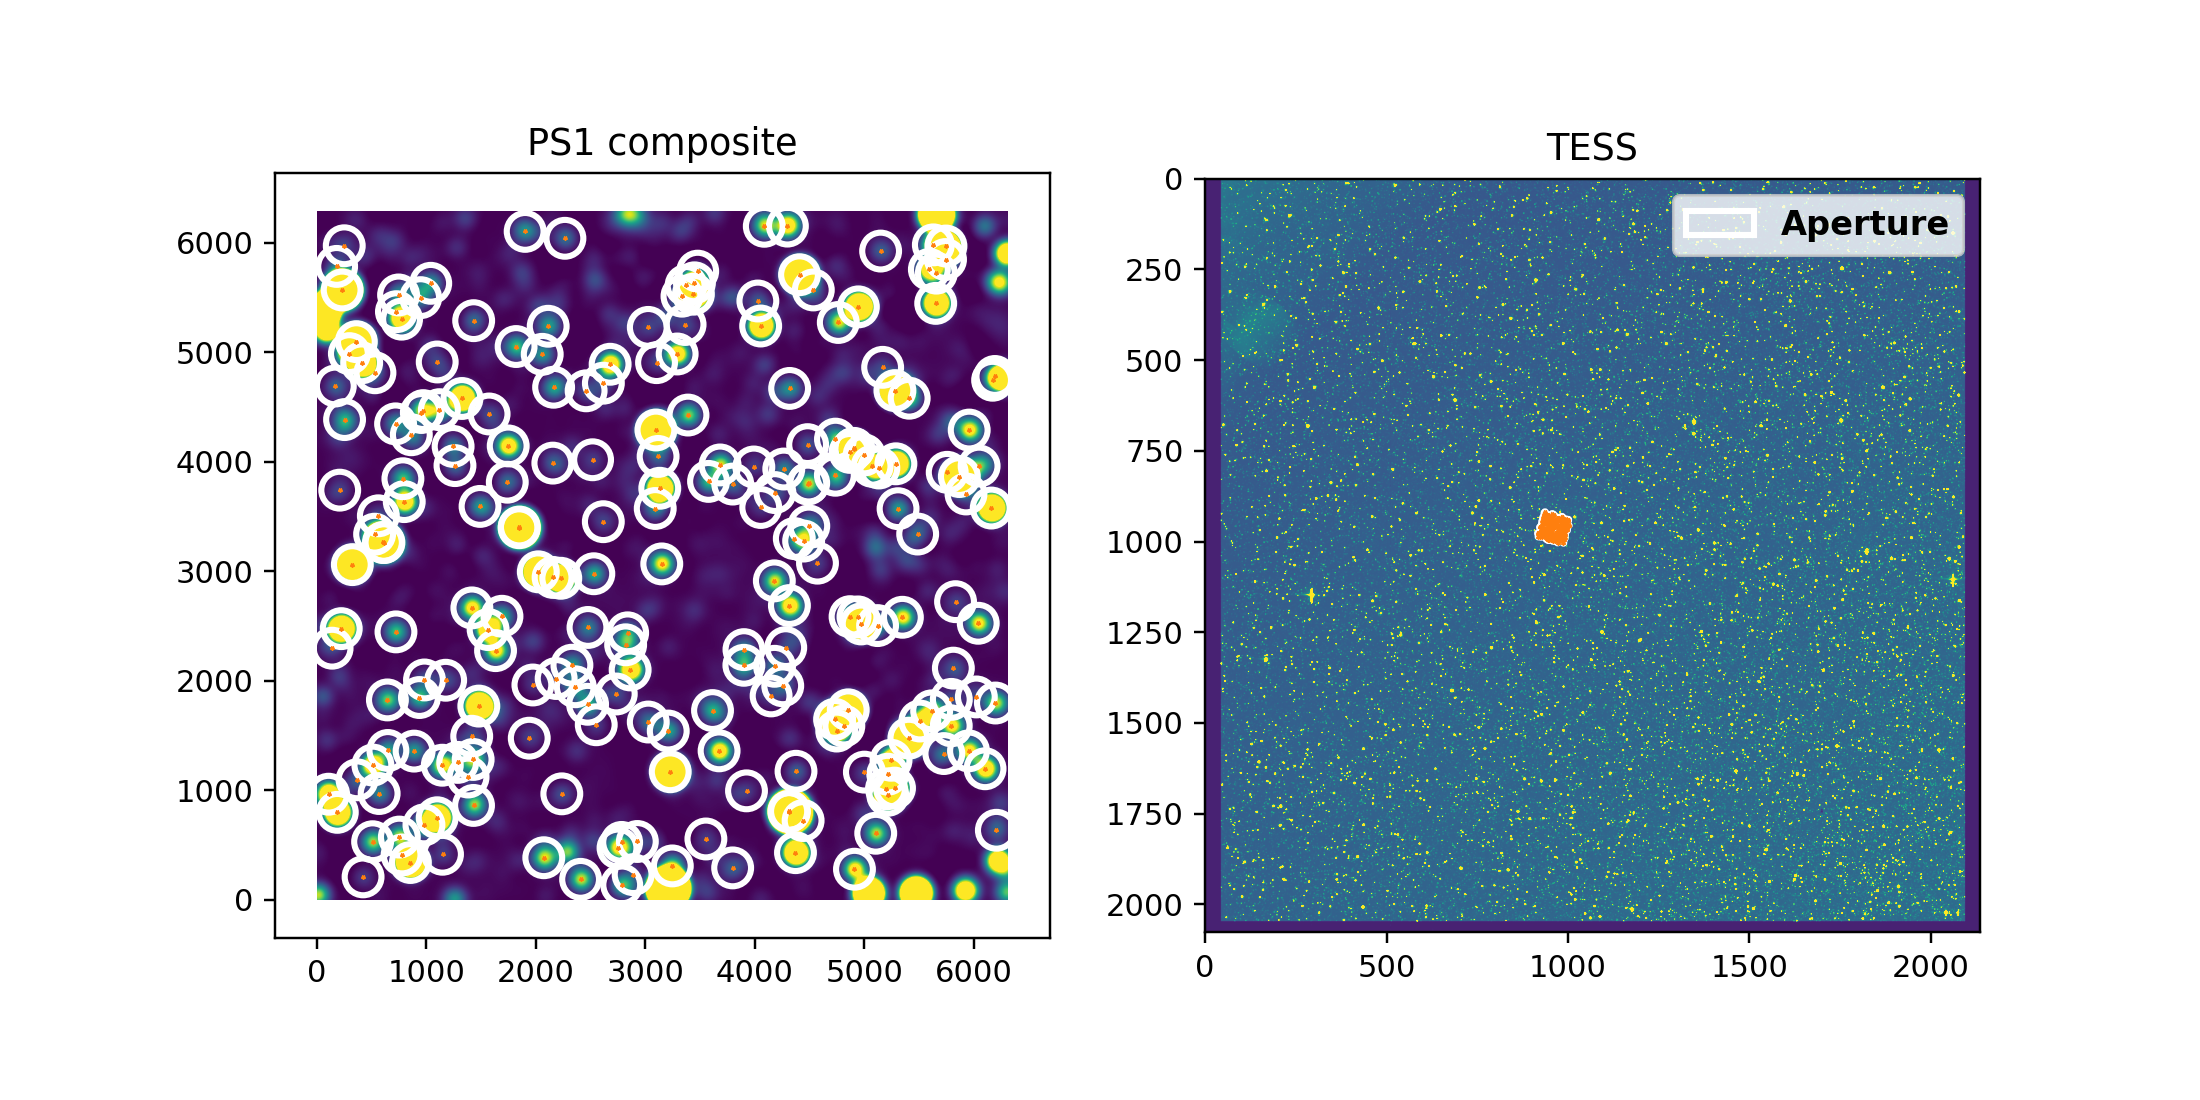

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('PS1 composite')
plt.imshow(ps1_tess,vmin=0,vmax=5e2,origin='lower')
plt.plot(sub.ps1x,sub.ps1y,'C1*',ms=1)
ap_patches = paperture.plot(color='white', lw=2,
                           label='Photometry aperture')


plt.subplot(122)
plt.subplot(122)

plt.title('TESS')
plt.imshow(tess_data,vmax=5e2)
plt.plot(sub.tessx,sub.tessy,'C1*',ms=1)
ap_patches = taperture.plot(color='white', lw=2,
                           label='Aperture')

handles = ([ap_patches[0]])
plt.legend(loc=1,
           handles=handles, prop={'weight': 'bold', 'size': 11})

<IPython.core.display.Javascript object>


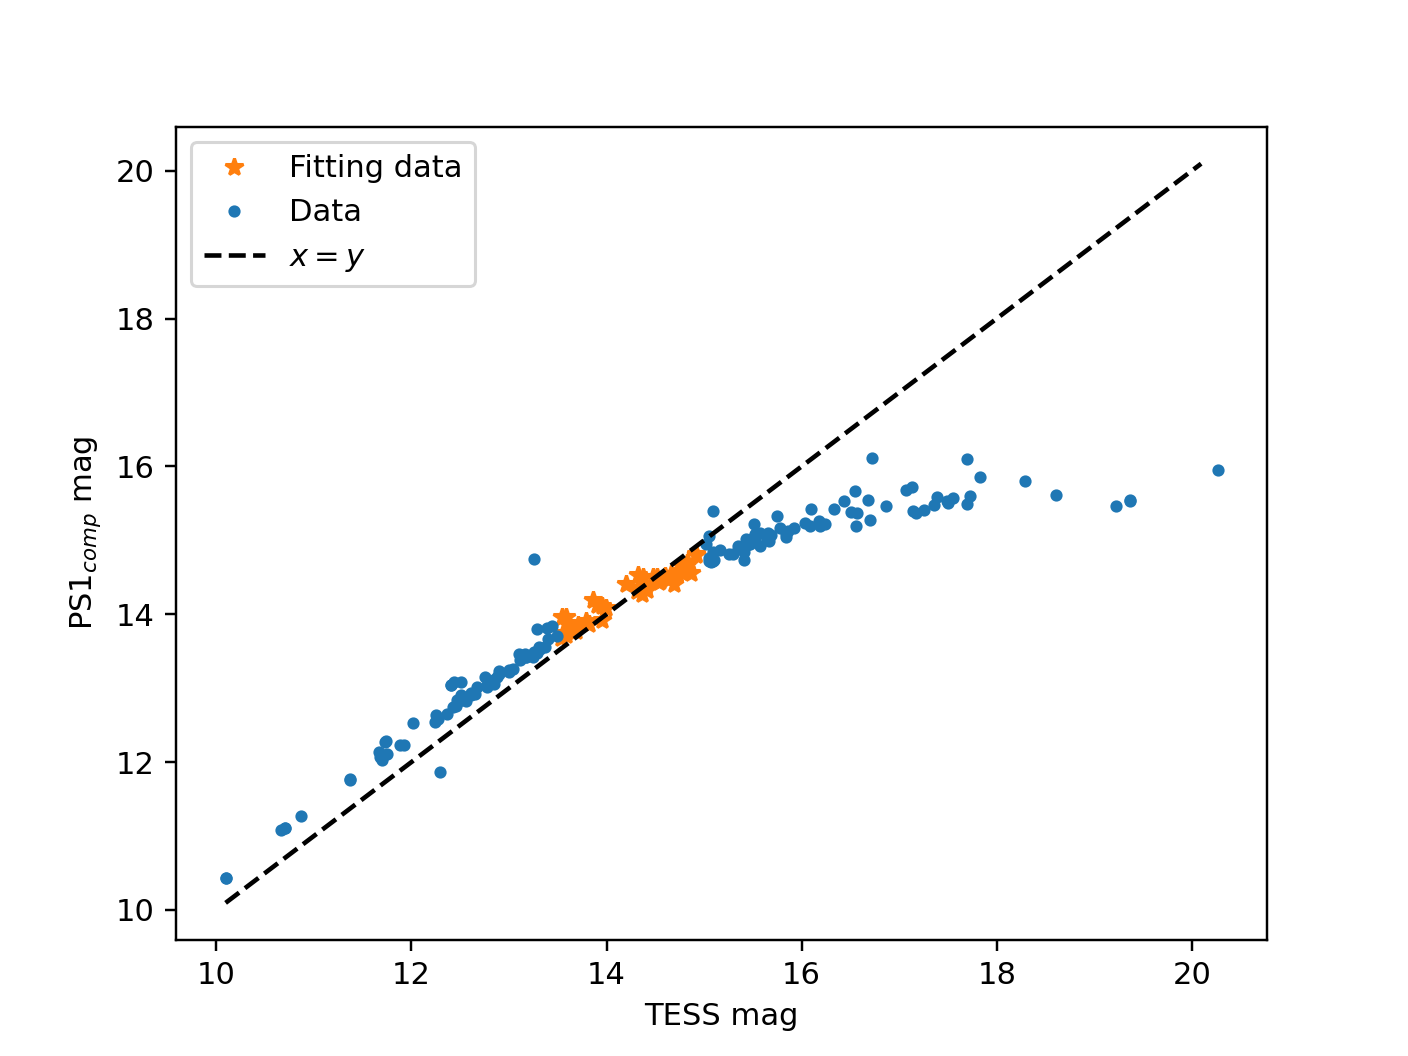

In [44]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


In [6]:
ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
registrations = glob('../PS1_to_TESS/bulk_test_buffer/*.npy')
skycell_path = '../data/ps1_skycell/'


scenes = []
for reg in registrations:
    ps1_assignment = np.load(reg).astype(int)
    skycell = reg.split('/')[-1].split('npy')[0]
    ps1_files = glob(skycell_path + skycell + '*.unconv.satcor.fits' )
    ps1 = {}
    for file in ps1_files:
        hdu = fits.open(file)
        header = hdu[0].header

        data = image2counts(hdu[0].data,header)
        m,med,std = sigma_clipped_stats(data)
        ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    #ps1_wcs = WCS(header)

    noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
    ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')
    # assign values 
    pind = ps1_assignment.ravel()
    tess_pixels = np.unique(pind)[1:]
    start = time.time()
    pind = ps1_assignment.ravel()
    sort_ind = np.argsort(pind)
    ps1_tess_rav = ps1_tess.ravel()[sort_ind]
    breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
    breaks = np.insert(breaks,-1,len(ps1_tess_rav))

    sums = []
    for i in range(len(breaks)-1):
        # first entry is 0, which is not assigned, so we can skip it
        sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]

    s = np.zeros_like(tess_data)
    s[ty[tess_pixels],tx[tess_pixels]] = sums
    print('Time: %s' % (time.time()-start))
    scenes += [s]
scenes = np.array(scenes)
scenes[scenes == 0] = np.nan
scene = np.nanmedian(scenes,axis=0)
    


Time: 0.7478699684143066
Time: 0.7555088996887207
Time: 0.7335278987884521
Time: 0.7352380752563477
Time: 0.7235152721405029
Time: 0.7253360748291016
Time: 0.7407500743865967
Time: 0.7285299301147461
Time: 0.7402989864349365
Time: 0.7314081192016602
Time: 0.7382321357727051
Time: 0.7279131412506104
Time: 0.7465243339538574
Time: 0.7450778484344482
Time: 0.730820894241333
Time: 0.7415060997009277
Time: 0.7550678253173828
Time: 0.7789289951324463
Time: 0.7465579509735107
Time: 0.7555327415466309
Time: 0.7840938568115234
Time: 0.7838902473449707
Time: 0.7651481628417969
Time: 0.7659327983856201


<IPython.core.display.Javascript object>


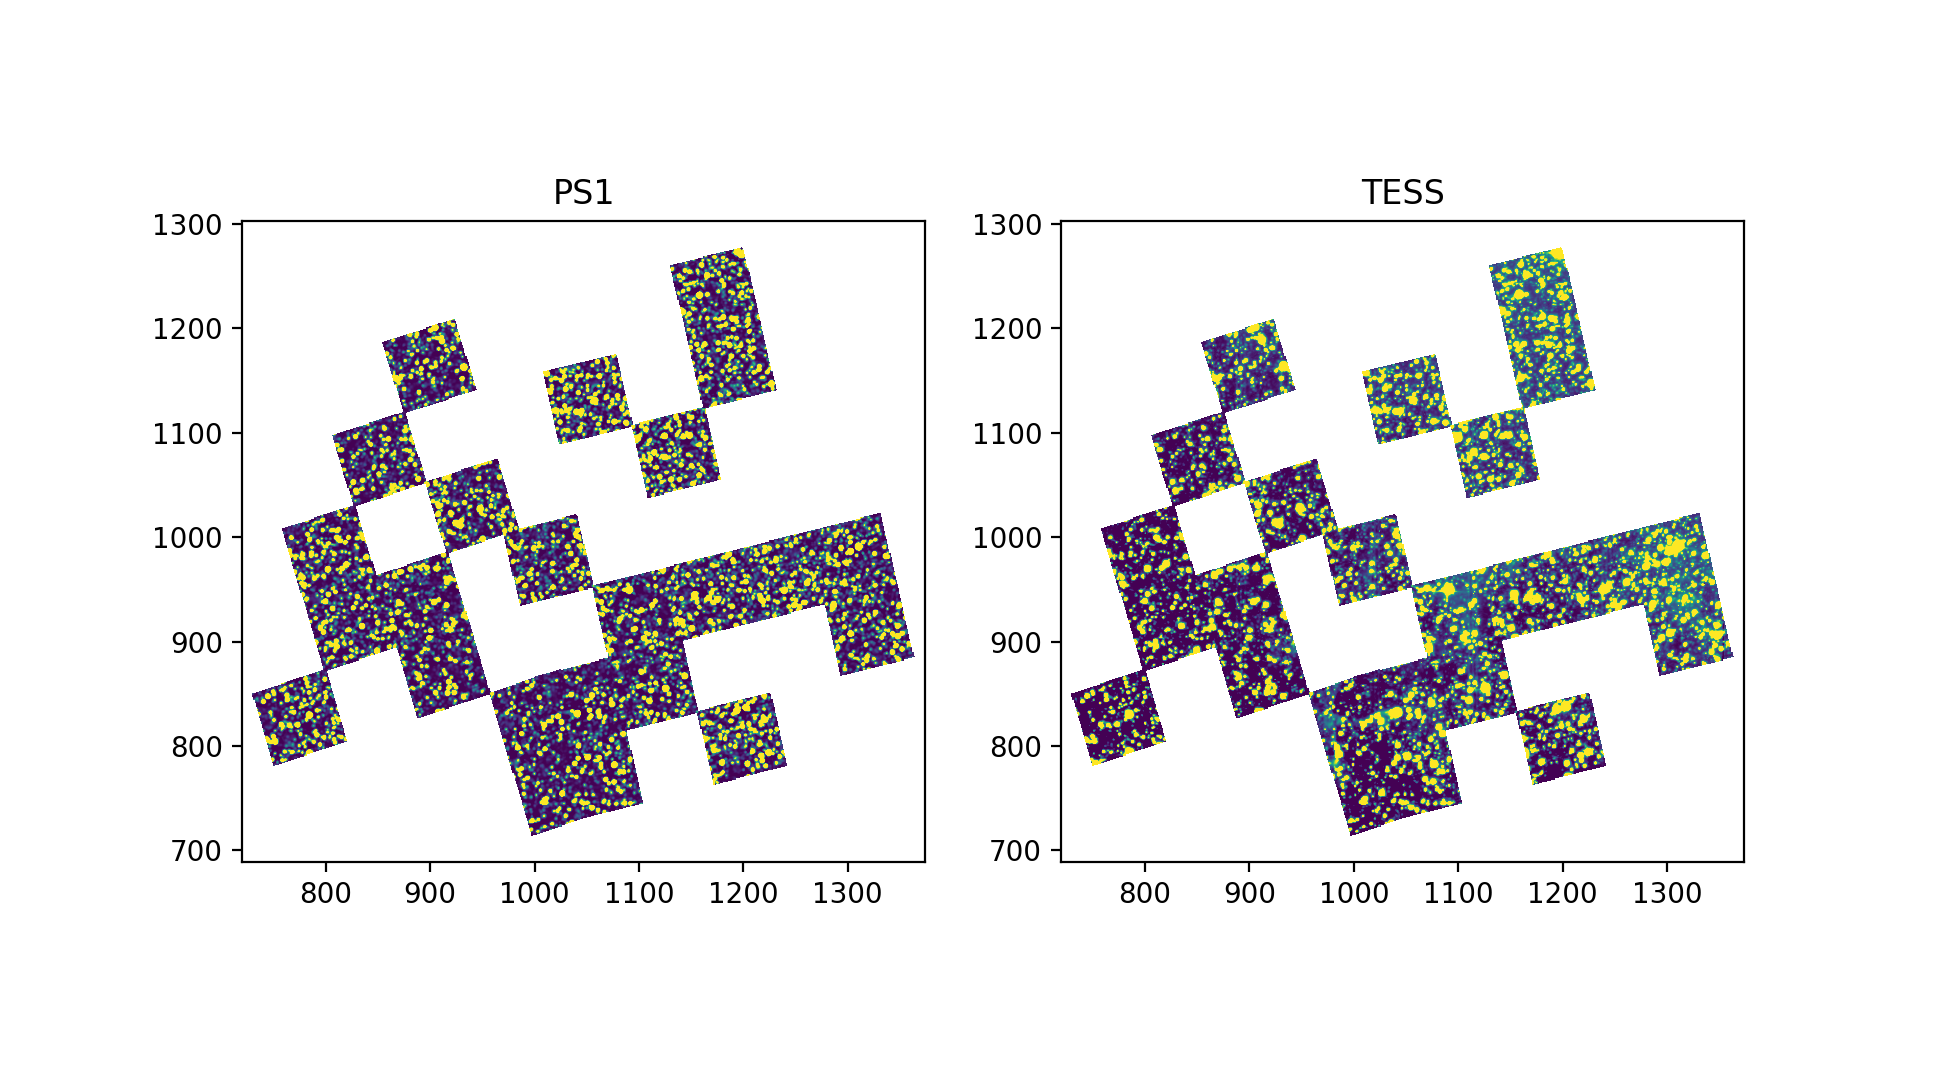

(689.0, 1303.0)

In [7]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

xmin = np.min(np.where(np.isfinite(s))[1]) - 10
xmax = np.max(np.where(np.isfinite(s))[1]) + 10
ymin = np.min(np.where(np.isfinite(s))[0]) - 10
ymax = np.max(np.where(np.isfinite(s))[0]) + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [26]:
xc = (xmax + xmin ) /2 
yc = (ymax + ymin )/2
ra_, dec_ = tess_wcs.all_pix2world(xc,yc,0)

In [23]:
xc

1047.0

In [12]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

In [24]:
radius=Angle(abs(xmin-xc) * 21 + 60, unit = u.arcsecond)

In [30]:
cat

objID      raMean    decMean  qualityFlag  gMeanPSFMag  \
0        155291136957993192  113.695806  39.410492           53  -999.000000   
1        155291136965893890  113.696543  39.411071           60    19.152700   
2        155291136972717138  113.697298  39.413735           60    19.913500   
3        155291136982663884  113.698318  39.411132           53    20.879700   
4        155291137160262590  113.716010  39.409949           61    19.192101   
...                     ...         ...        ...          ...          ...   
2776830  176741209811113002  120.981060  57.285244           61    20.421000   
2776831  176741210303295822  121.030308  57.287601           52    19.817301   
2776832  176741210993662349  121.099356  57.284720           60    17.165100   
2776833  176751202736751602  120.273654  57.292404           60    21.008499   
2776834  176751206390320448  120.638993  57.291428           60    15.905000   

         gMeanPSFMagErr  gMeanPSFMagNpt  rMeanPSFMag  rMeanPSFMagErr  \
0           -999.000000               0    19.274700        0.014096   
1              0.019488               9    18.384800        0.007607   
2              0.036746               8    18.558100        0.007379   
3              0.033342               4    20.238800        0.051360   
4              0.019311               8    18.226101        0.059913   
...                 ...             ...          ...             ...   
2776830        0.015899              17    19.204100        0.020532   
2776831        0.014738              15    19.475901        0.018656   
2776832        0.004903              13    16.615299        0.004161   
2776833        0.022290              15    19.704800        0.026805   
2776834        0.002903               9    15.374000        0.001249   

         rMeanPSFMagNpt  ...    gFlags  gQfPerfect    rFlags  rQfPerfect  \
0                    10  ...     16416 -999.000000  16892216    0.999296   
1                    14  ...  16892216    0.999623    115000    0.999711   
2                    17  ...    115000    0.999833    115000    0.999762   
3                    13  ...  16892216    0.999141  16892216    0.999109   
4                     7  ...  16892216    0.999463  16892216    0.999409   
...                 ...  ...       ...         ...       ...         ...   
2776830               7  ...  16892216    0.999827  16892216    0.999659   
2776831              12  ...    115000    0.999752    115000    0.999678   
2776832               6  ...    115000    0.999679    115000    0.999207   
2776833               6  ...    115000    0.999572    115000    0.999659   
2776834               4  ...    115000    0.999431    115000    0.999707   

           iFlags  iQfPerfect    zFlags  zQfPerfect    yFlags  yQfPerfect  
0        16892216    0.999792  16892216    0.999173  16892216    0.999539  
1          115000    0.999712    115000    0.999343  16892216    0.999572  
2          115000    0.999705    115000    0.999219    115000    0.999201  
3        16892216    0.999711  16892216    0.999618  16892216    0.999288  
4        16892216    0.999646  16892216    0.999382  16892216    0.999287  
...           ...         ...       ...         ...       ...         ...  
2776830  16892216    0.999610  16892216    0.999724  16892216    0.999593  
2776831    115000    0.999669    115000    0.999425    115000    0.999575  
2776832    115000    0.999628    115000    0.999592    115000    0.999278  
2776833    115000    0.999289    115000    0.999383    115000    0.999486  
2776834    115000    0.999296    115000    0.999595    115000    0.999290  

[2776835 rows x 34 columns]

In [32]:
cat = pd.read_csv('/Users/rri38/Downloads/syndiff_test_field_rridden.csv')
_tx,_ty = tess_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = _tx; cat['tessy'] = _ty
cat = PS1_to_TESS_mag(cat)

sub = cat.loc[(cat.iMeanPSFMag < 17) ]# & (cat.rMeanPSFMag > 12)
#sub = cat.loc[(cat.tmag < 14) & np.isfinite(cat.tmag)  & (cat.rMeanPSFMag > 14)]
ind = ((sub.tessy.values>2) & (sub.tessy.values<tess_data.shape[0]-2) &
       (sub.tessx.values>2) & (sub.tessx.values<tess_data.shape[1]-2))

sub = sub.loc[ind]

subsub = sub.iMeanPSFMag.values >14

In [68]:
scale = 21/0.25
ap_size = 1.5
pos = list(zip(sub.tessx, sub.tessy))
taperture = CircularAperture(pos, ap_size)
a = t
#m,med,std = sigma_clipped_stats(a)
tphot_table = aperture_photometry(a, taperture)
#tphot_table = aperture_photometry(tess.ref, taperture)


pphot_table = aperture_photometry(scene, taperture)

ptmag = -2.5*np.log10(pphot_table['aperture_sum'].value)
tmag = -2.5*np.log10(tphot_table['aperture_sum'].value)
ind = np.isfinite(tmag) & np.isfinite(ptmag)

ptmag = ptmag[ind]
tmag = tmag[ind]

In [86]:
subsub = (tmag >-12) & (tmag < -9)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1,fixed={'slope': True})
line_flexi = models.Linear1D(slope=1)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tmag[subsub], ptmag[subsub])
flexi_line, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
filtered_data = np.ma.masked_array(ptmag[subsub], mask=mask)

<IPython.core.display.Javascript object>


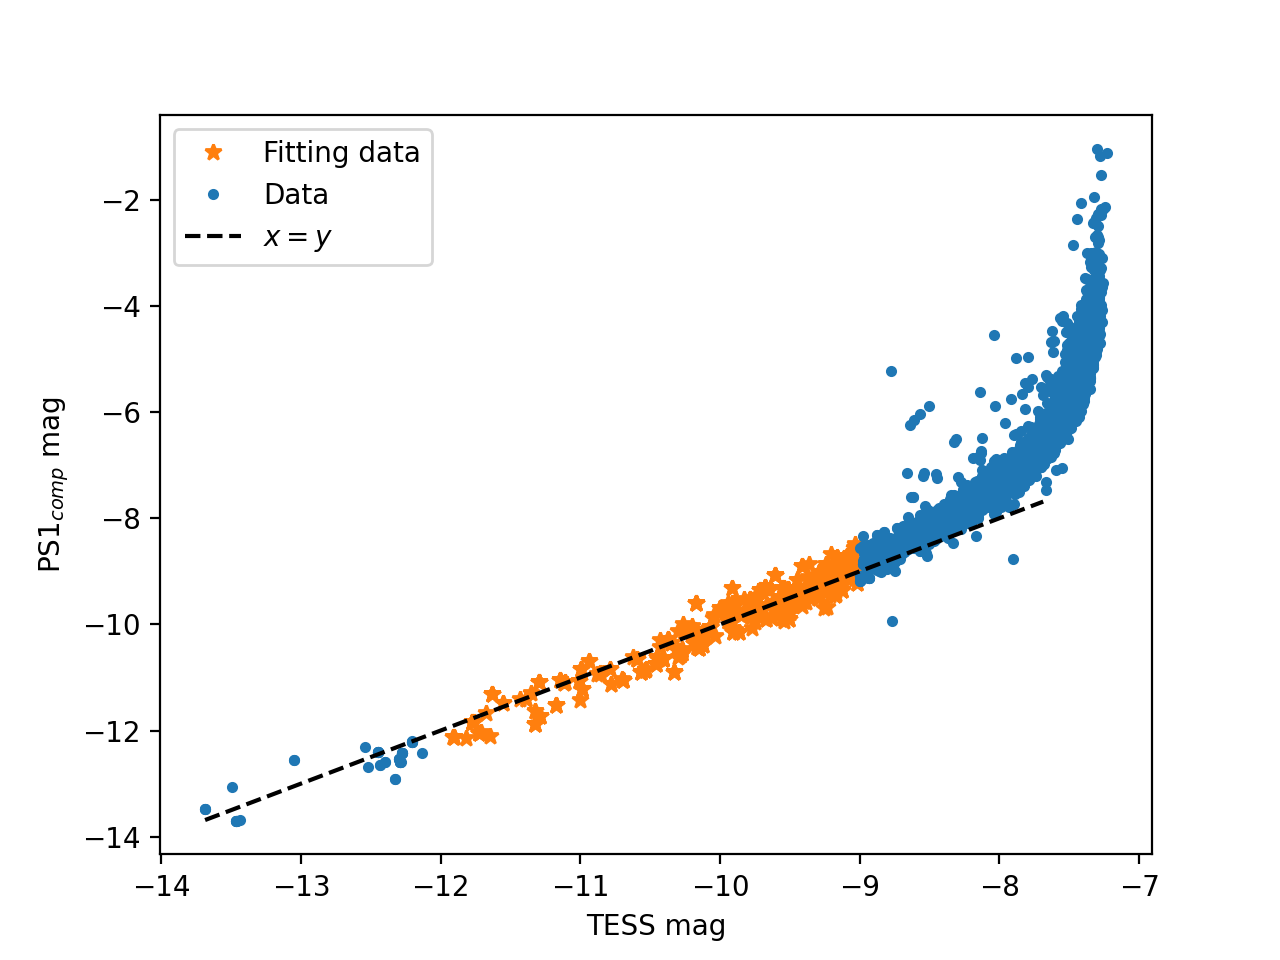

In [87]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


## Fit fluxes

In [97]:
subsub = (tphot_table['aperture_sum'].value[ind] >1100)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1)


# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tphot_table['aperture_sum'].value[ind][subsub], pphot_table['aperture_sum'].value[ind][subsub])
filtered_data = np.ma.masked_array(pphot_table['aperture_sum'].value[ind][subsub], mask=mask)

<IPython.core.display.Javascript object>


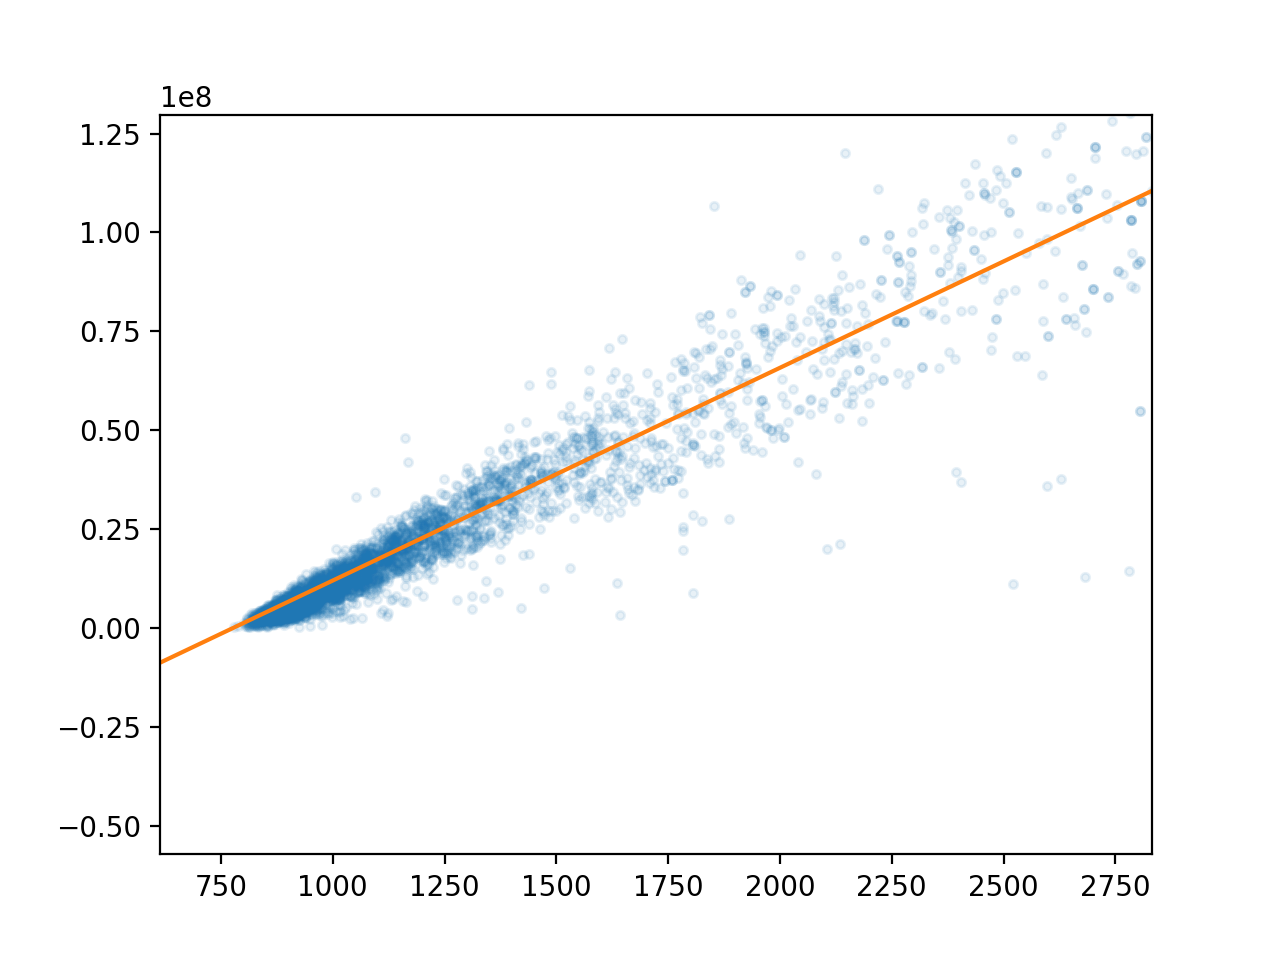

In [98]:
x = np.arange(0,np.nanmax(tphot_table['aperture_sum'].value))
plt.figure()
plt.plot(tphot_table['aperture_sum'].value,pphot_table['aperture_sum'].value,'.',alpha=0.1)
plt.plot(x,fitted_line(x))

In [ ]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


In [65]:
tind = tmag > -5

## test shifting 

In [106]:
from scipy.ndimage import shift

In [107]:
ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
registrations = glob('../PS1_to_TESS/bulk_test_buffer/*.npy')
skycell_path = '../data/ps1_skycell/'

offset = [20,-5]
scenes = []
for reg in registrations:
    ps1_assignment = shift(np.load(reg).astype(int),offset)
    skycell = reg.split('/')[-1].split('npy')[0]
    ps1_files = glob(skycell_path + skycell + '*.unconv.satcor.fits' )
    ps1 = {}
    for file in ps1_files:
        hdu = fits.open(file)
        header = hdu[0].header

        data = image2counts(hdu[0].data,header)
        m,med,std = sigma_clipped_stats(data)
        ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    #ps1_wcs = WCS(header)

    noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
    ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')
    # assign values 
    pind = ps1_assignment.ravel()
    tess_pixels = np.unique(pind)[1:]
    start = time.time()
    pind = ps1_assignment.ravel()
    sort_ind = np.argsort(pind)
    ps1_tess_rav = ps1_tess.ravel()[sort_ind]
    breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
    breaks = np.insert(breaks,-1,len(ps1_tess_rav))

    sums = []
    for i in range(len(breaks)-1):
        # first entry is 0, which is not assigned, so we can skip it
        sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]

    s = np.zeros_like(tess_data)
    s[ty[tess_pixels],tx[tess_pixels]] = sums
    print('Time: %s' % (time.time()-start))
    scenes += [s]
scenes = np.array(scenes)
scenes[scenes == 0] = np.nan
shift_scene = np.nanmedian(scenes,axis=0)
    


Time: 0.7693719863891602
Time: 0.7717618942260742
Time: 0.7549450397491455
Time: 0.7814631462097168
Time: 0.7405450344085693
Time: 0.7478351593017578
Time: 0.7970221042633057
Time: 0.7581372261047363
Time: 0.8233411312103271
Time: 0.7687380313873291
Time: 0.7542212009429932
Time: 0.7880859375
Time: 0.7575969696044922
Time: 0.7891530990600586
Time: 0.7408151626586914
Time: 0.7379031181335449
Time: 0.7630822658538818
Time: 0.7362058162689209
Time: 0.7396719455718994
Time: 0.7848689556121826
Time: 0.7649111747741699
Time: 0.7507390975952148
Time: 0.7522313594818115
Time: 0.7555460929870605


<IPython.core.display.Javascript object>


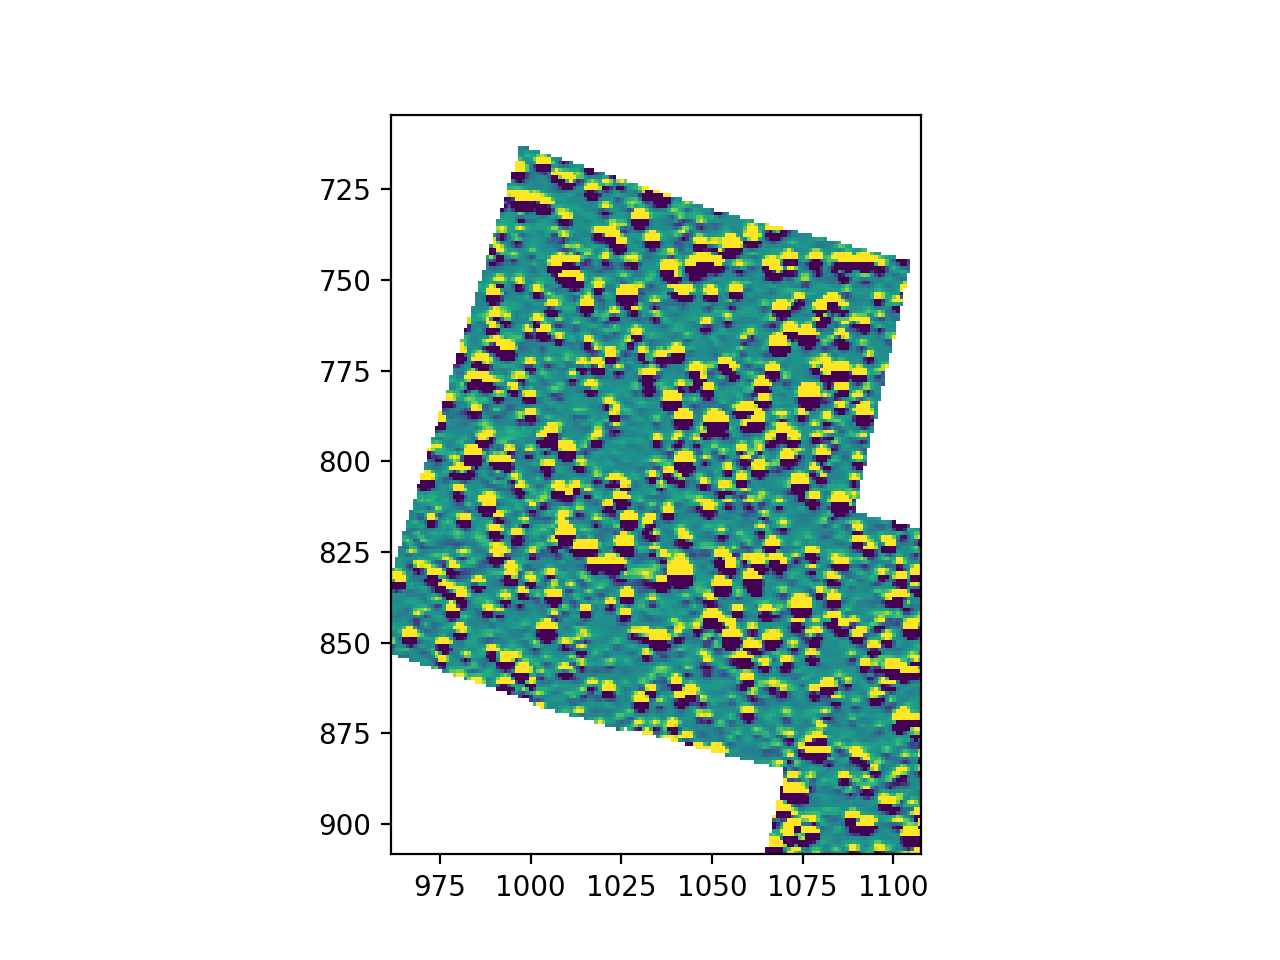

In [111]:
diff =scene-shift_scene
vmin = np.nanpercentile(diff,16)
vmax = np.nanpercentile(diff,84)
plt.figure()
plt.imshow(diff,vmin=vmin,vmax=vmax)

In [66]:
question = tphot_table[ind][tind]

<IPython.core.display.Javascript object>


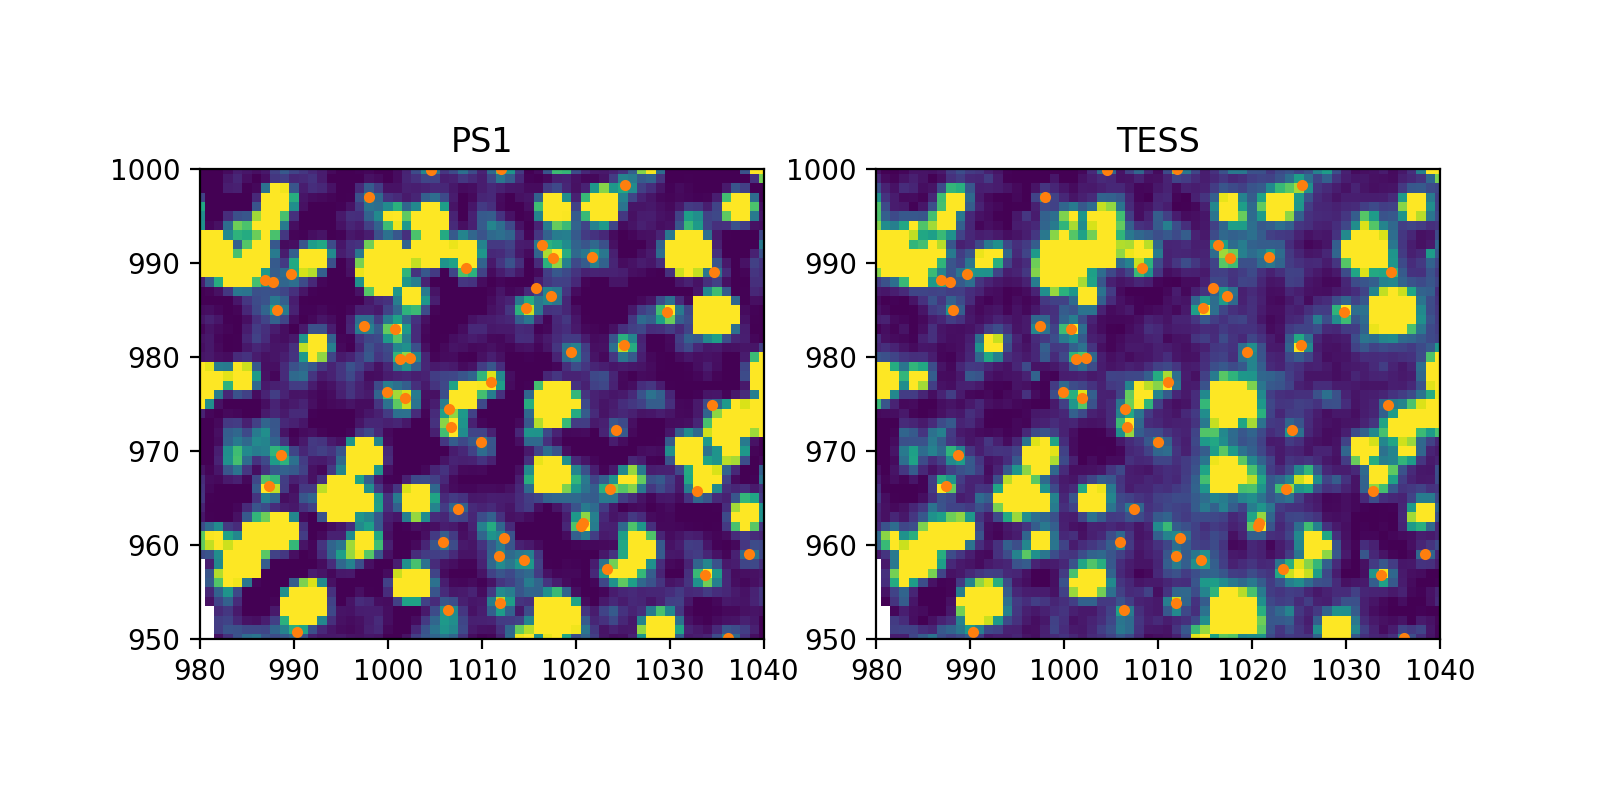

In [79]:
xmin = np.min(np.where(np.isfinite(s))[1]) - 10
xmax = np.max(np.where(np.isfinite(s))[1]) + 10
ymin = np.min(np.where(np.isfinite(s))[0]) - 10
ymax = np.max(np.where(np.isfinite(s))[0]) + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
plt.xlim(980,1040)
plt.ylim(950,1000)
plt.plot(question['xcenter'],question['ycenter'],'C1.')
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
plt.xlim(980,1040)
plt.ylim(950,1000)
plt.plot(question['xcenter'],question['ycenter'],'C1.')

<IPython.core.display.Javascript object>


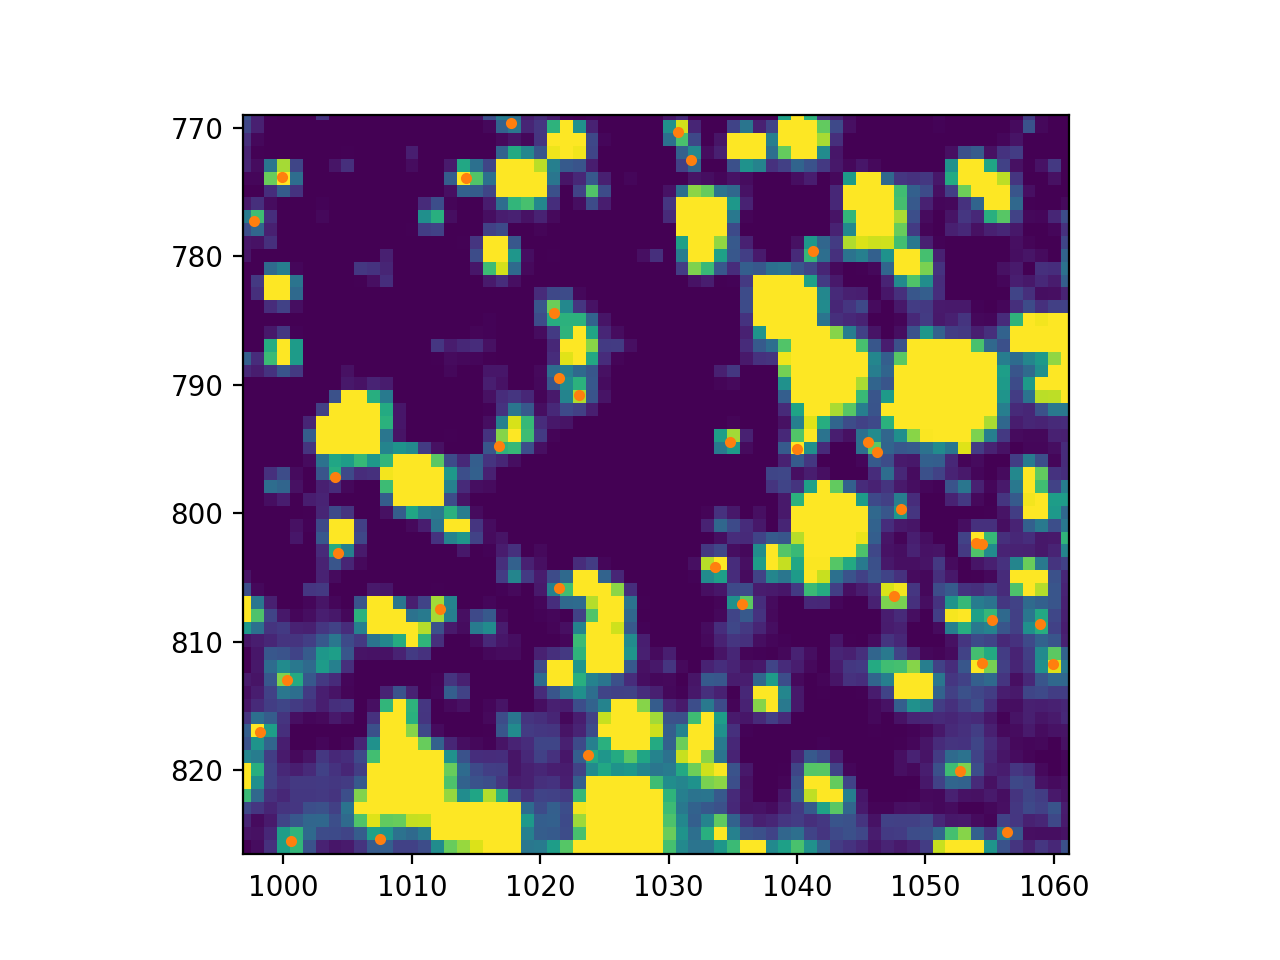

In [60]:
plt.figure()
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.plot(question['xcenter'],question['ycenter'],'C1.')

In [48]:
fitted_line.parameters

array([  1.        , -11.92847564])

In [110]:
tess_pixels = np.unique(pind)[1:]

In [112]:
tess_pixels.shape

(5906,)

In [99]:
breaks = np.where(np.diff(pind[sort_ind])> 0)[0]

In [104]:
len(np.unique(pind))

5907

In [101]:
len(pind[breaks])

5906

In [90]:
breaks

array([       0,   248971,   254576, ..., 39653333, 39664723, 39660121])

In [92]:
np.nansum(ps1_tess_raw[breaks[0]:breaks[1]])

178772633.6239983

In [97]:
pind[sort_ind][breaks]

IndexError: index 39664723 is out of bounds for axis 0 with size 39664723

[178772633.6239983,
 5534471.056222131,
 5636598.017043559,
 4481199.96953631,
 6182852.444745507,
 6307785.1092449045,
 5953101.905306262,
 5938109.3171606865,
 5789457.8181391,
 923599.2854661944,
 9663851.242063113,
 6057780.0766408155,
 6091083.987087073,
 6129994.264734541,
 6387582.966625285,
 6707204.022983358,
 6847034.5978176985,
 5588043.8212004285,
 971495.6628104325,
 6280438.61259209,
 6400193.012507018,
 6409205.663768269,
 6449427.901545408,
 6501707.156079311,
 6889051.051285716,
 11136946.383422513,
 6633405.044960437,
 6650120.064795751,
 6679006.224584864,
 6867705.626694897,
 6578667.742116762,
 1565931.3981139243,
 6768509.53895605,
 6815419.589902351,
 6859038.301982798,
 10513142.060239535,
 8470731.226845663,
 6926395.699822023,
 6945326.422525672,
 6964589.311733127,
 7541639.662929291,
 7586147.027283917,
 7237911.165868665,
 7147971.161786325,
 7091846.120447006,
 7074862.177785213,
 7079009.88616381,
 5617175.448195346,
 7116425.877249092,
 7126817.990454563

In [70]:
max(tx)

2135

In [71]:
t_x

2136

In [72]:
start = time.time()
scene = np.zeros_like(tess_data)
#  range(1000):#
for i in range(len(pind)):
    scene[ty[pind[i]],tx[pind[i]]] += ps1_tess[py[i],px[i]]
print('Time: %s' % (time.time()-start))

Time: 37.14375281333923


In [73]:
np.any(scene)

True

<IPython.core.display.Javascript object>


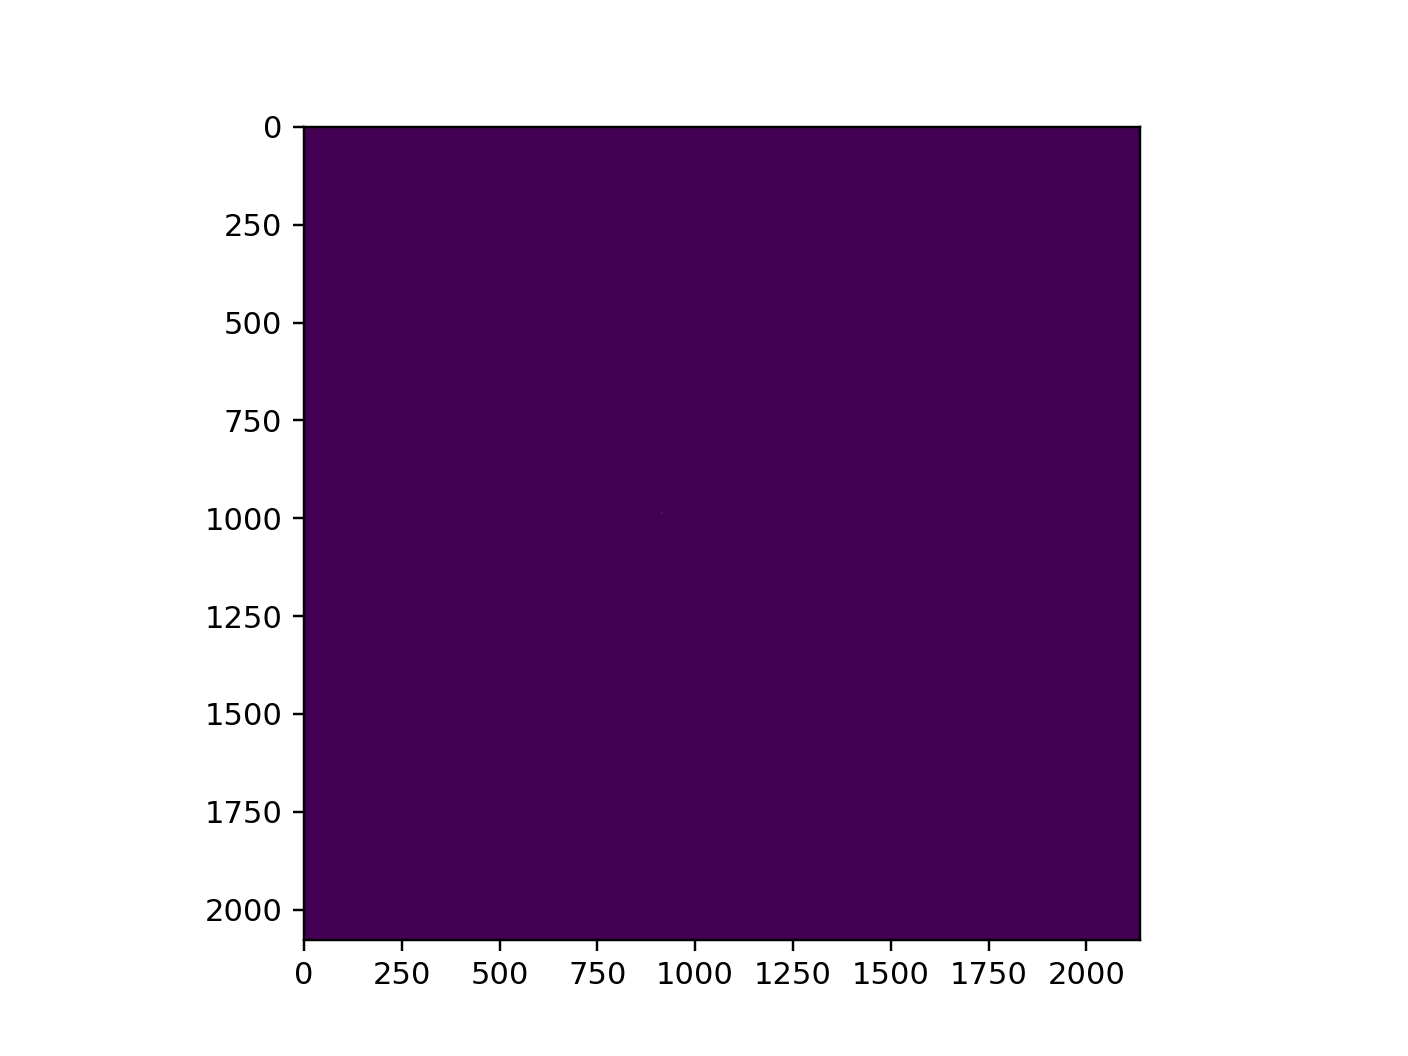

In [57]:
plt.figure()
plt.imshow(scene)

In [17]:
scene = np.zeros_like(tess_data)

for ind in assigned_tess:
    
    scene[ty[ind],tx[ind]] = np.sum(ps1_tess[ps1_assignment == ind])

KeyboardInterrupt: 

In [74]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

In [75]:
np.nansum(s > 0)

5469

In [76]:
yint,xint = np.where(np.isfinite(s))


<IPython.core.display.Javascript object>


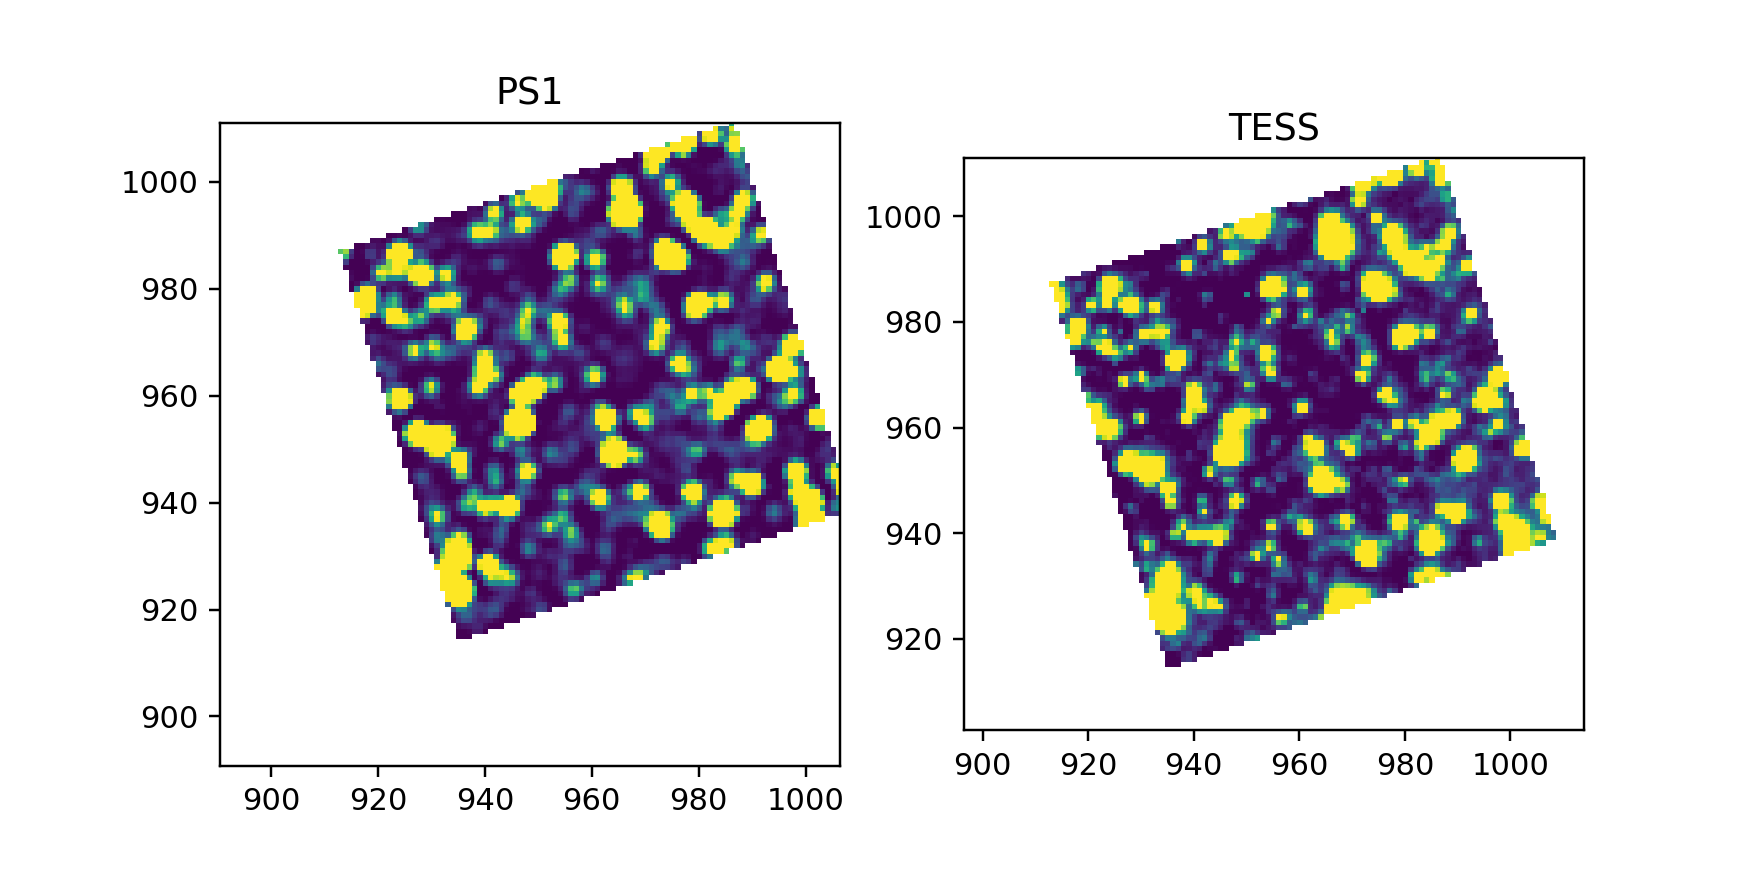

(-25.0, 1011.0)

In [78]:
xmin = np.where(np.isfinite(s))[0][0] - 10
xmax = np.where(np.isfinite(s))[0][-1] + 10
ymin = np.where(np.isfinite(s))[1][0] - 10
ymax = np.where(np.isfinite(s))[1][-1] + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [62]:
ind = np.where(ps1_assignment == assigned_tess[1])
ps1_tess[ind[0],ind[1]]

array([0.8400738 , 0.76334559, 0.80271631, ..., 1.63023859, 1.67886581,
       1.7281307 ])

In [63]:
ps1_assignment[ps1_assignment]

IndexError: index 2109145 is out of bounds for axis 0 with size 6289

In [ ]:
plt.figure()
plt.imshow(ps1_tess)

<IPython.core.display.Javascript object>


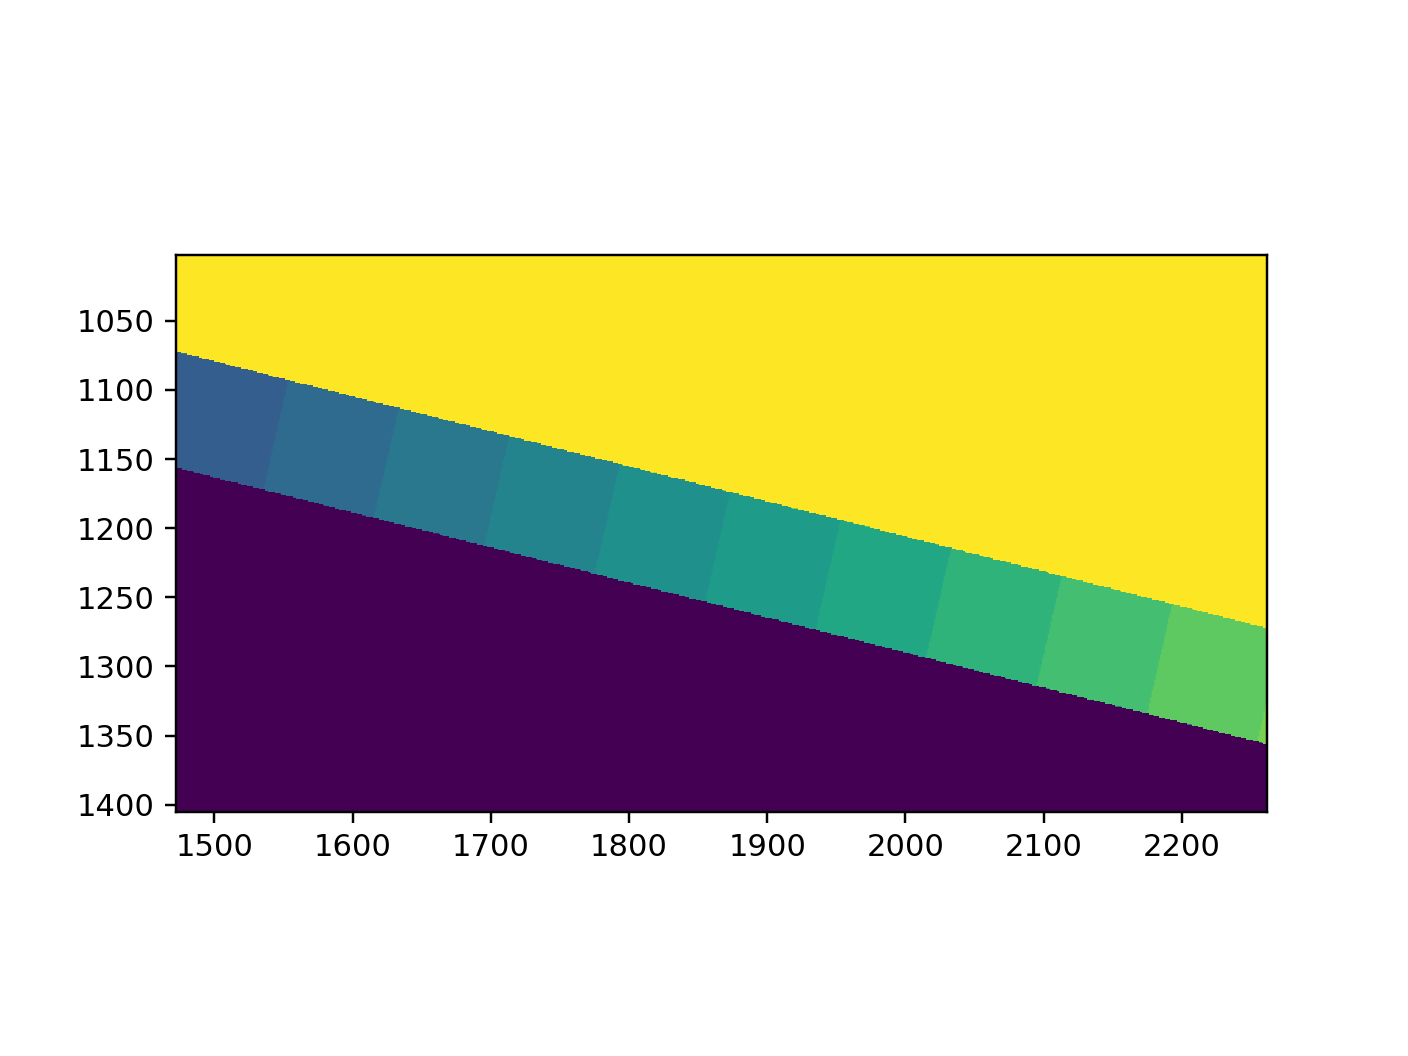

In [27]:
plt.figure()
plt.imshow(ps1_assignment,vmin = ps1_assignment[1000,1000],vmax = ps1_assignment[1000,1000]+20)